In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, f1_score, make_scorer, fbeta_score
from sklearn.decomposition import PCA

In [3]:
full_data = pd.read_csv("../data/processed/full_all_day_ahead.csv")
full_data.head()

cols_1_day_ahead = [c for c in full_data.columns if c == "Abnormal" or c.endswith("_1")]
data_1_day_ahead = full_data[cols_1_day_ahead]

data_1_day_ahead[data_1_day_ahead.isna().any(axis=1)]

,ACWO_1,ADMO_1,ADRR_1,CSO_1,DPB_1,DPH_1,HTB_1,HTH_1,ITP_1,OGO_1,PPL_1,PS_1,RRIR_1,RRR_1,RR_1,TAGI_1,TGA_1,TLRR_1,Abnormal
2450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [4]:
data_1_day_ahead_nadropped = data_1_day_ahead.dropna()

X_1da_nadrop = data_1_day_ahead_nadropped[[c for c in cols_1_day_ahead if c != "Abnormal"]]
y_1da_nadrop = data_1_day_ahead_nadropped["Abnormal"]

y_1da_nadrop.value_counts() / len(y_1da_nadrop)

Abnormal
False    0.986301
True     0.013699
Name: count, dtype: float64

In [5]:
X_scaler = StandardScaler()
X_scaler.fit(X_1da_nadrop)
X_scaled = X_scaler.transform(X_1da_nadrop)

In [6]:
y_encoder = LabelEncoder()
y_bin = y_encoder.fit_transform(y_1da_nadrop)
1-np.mean(y_bin)

0.9863013698630136

### Logistic Regression

In [17]:
np.random.seed(123)

ftwo_scorer = make_scorer(fbeta_score, beta=2)

lr = LogisticRegressionCV(max_iter=250000, n_jobs=-1, class_weight="balanced", 
                          cv=10, scoring=ftwo_scorer, Cs=10, refit=True)

lr.fit(X_scaled, y_bin)

LogisticRegressionCV(class_weight='balanced', cv=10, max_iter=250000, n_jobs=-1,
                     scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [18]:
lr.C_

array([0.04641589])

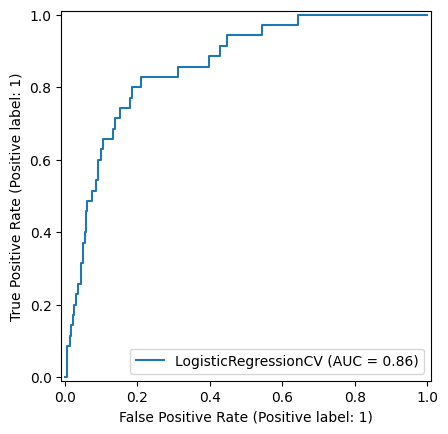

In [19]:
RocCurveDisplay.from_estimator(lr, X_scaled, y_bin)

In [20]:
threshholds = [i/20 for i in range(21)]
f1s = [fbeta_score(y_bin, [0 if p < t else 1 
                        for p in lr.predict_proba(X_scaled)[:,1]], beta=2) 
       for t in threshholds]

In [21]:
threshholds[np.argmax(f1s)]

0.7

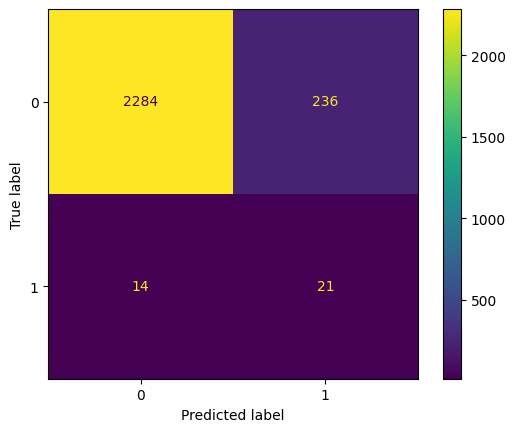

In [22]:
ConfusionMatrixDisplay.from_predictions(
  y_bin,
  [0 if p < 0.7 else 1 for p in lr.predict_proba(X_scaled)[:,1]]
)